In [189]:
import SimpleITK as sitk
import numpy as np
import sigpy as sp
from sigpy import plot
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)
t1_slice=t1[0,0,45,:,:]

print(t1.shape)
print(t1_slice.shape)

(2, 1, 90, 256, 256)
(256, 256)


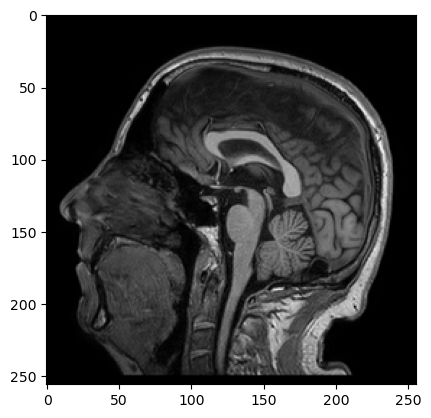

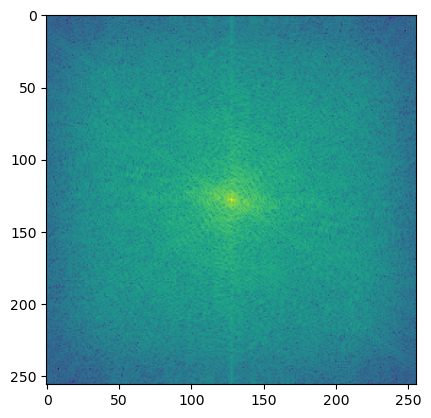

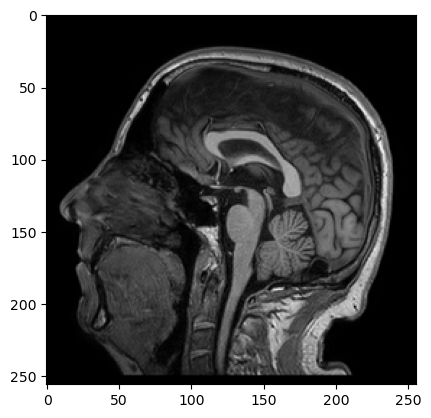

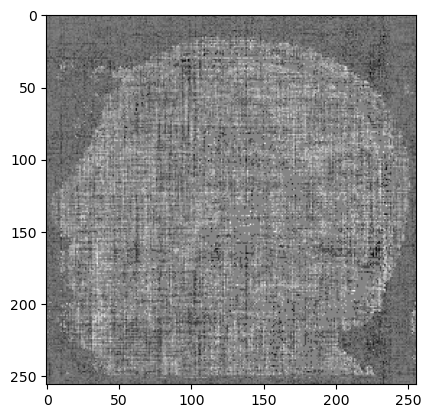

In [203]:
plt.figure()
plt.imshow(t1_slice, cmap='gray')
plt.show()

fft_t1_slice = sp.fft(t1_slice, center=True)
plt.figure()
plt.imshow(np.log10(abs(fft_t1_slice)))
plt.show()

original_img = sp.ifft(fft_t1_slice, center=True)

plt.figure()
plt.imshow(abs(original_img), cmap="gray")
plt.show()

plt.figure()
plt.imshow(t1_slice - abs(original_img), cmap="gray")
plt.show()

# 1. Simulation of radial sampling: (15%)

(128, 256, 2)
127.5
-127.49848289473377


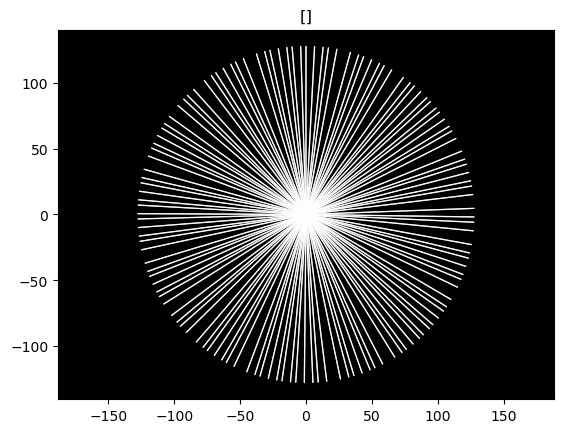

In [276]:
spikes = 128
coord = sp.mri.radial((spikes,256,2),(256,256))
print(coord.shape)
print(coord.max())
print(coord.min())

sp.plot.ScatterPlot(coord)

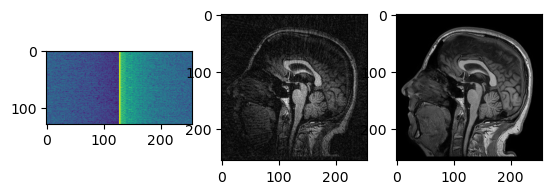

(128, 256)
549
7960.56529930952
180097.4141183626
22741.18359375
1018.1906769376408


In [277]:
#new_fft = np.zeros_like(fft_t1_slice)
#new_fft[coord[:,:,1],coord[:,:,0]] = fft_t1_slice[coord[:,:,1],coord[:,:,0]]
#fft_t1_slice /= abs(fft_t1_slice).max()
#fft_t1_slice = np.ones((256, 256))

coord = sp.mri.radial((spikes,256,2),(256,256))
#new_fft = sp.interpolate(fft_t1_slice, coord + 256/2)
new_fft = sp.interpolate(fft_t1_slice, coord + 256/2)
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
grd = sp.gridding(new_fft * dcf, coord, shape=(256, 256), param=2)
#grd = sp.gridding(new_fft, coord, shape=(256, 256))


#new_fft = sp.interpolate(fft_t1_slice, coord2)
#dcf = (coord[..., 0]**2 + coord2[..., 1]**2)**0.5
#grd = sp.gridding(new_fft, coord2, shape=(256, 256))


#grd = sp.gridding(new_fft, coord, shape=(256, 256))

# normalize and scale to original fft
#grd = (grd / grd.max()) * fft_t1_slice.max()

new_ifft = sp.ifft(grd, center=True)
plt.figure()
plt.subplot(131)
plt.imshow(np.fft.fftshift(np.log10(abs(grd)+1)))
plt.imshow(np.fft.fftshift(np.log10(abs(new_fft)+1)))
#plt.imshow(dcf, cmap="gray")

plt.subplot(132)
plt.imshow(abs(new_ifft), cmap='gray')

plt.subplot(133)
#plt.imshow(abs(t1_slice - abs(new_ifft)), cmap='gray')
plt.imshow(abs(t1_slice), cmap='gray')
plt.show()

print(new_fft.shape)
print(t1_slice.max())
print(abs(new_ifft).max())
print(abs(grd).max())
print(abs(fft_t1_slice).max())
print(np.mean(abs(t1_slice - abs(new_ifft))))

Acceleration factor:  1.0


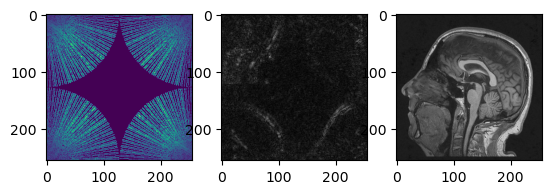

Acceleration factor:  2.0


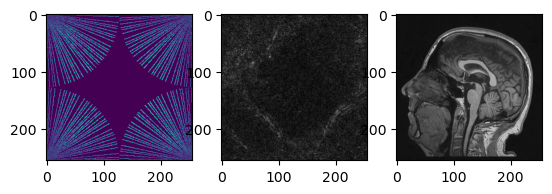

Acceleration factor:  4.0


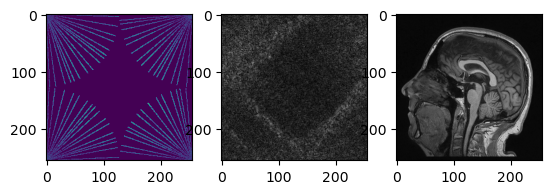

Acceleration factor:  9.846153846153847


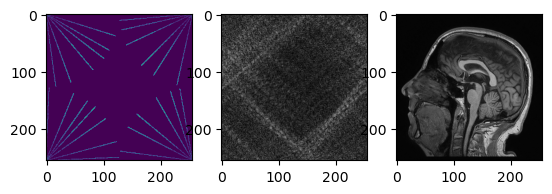

In [274]:
# compute acceleration factor:
# acceleration factor is number of sample points with cartesian sampling divided by number of sampling points with radial points:
# acc = (256*256)/(n_spikes*samples_per_spikes) -> with samples_per_spikes=256:  n_spikes = 256/acc
# acc in [1, 10]: upper boundary: n_spikes >= 256/10 = 25.6; lower boundary: n_spikes <= 256/1 = 256
# --> Values for spikes between 26 and 156 spikes are permissible

n_spikes = [256, 128, 64, 26] # list of number of spikes

ffts = [] # list to store ffts
iffts = [] # list to store subsampled images

for n in n_spikes:
    coord = sp.mri.radial((n,256,2), (256,256), dtype=int)
    tmp_fft = np.zeros_like(fft_t1_slice)
    tmp_fft[coord[:,:,1],coord[:,:,0]] = fft_t1_slice[coord[:,:,1],coord[:,:,0]]
    ffts.append(tmp_fft)
    iffts.append(abs(sp.ifft(tmp_fft, center=False)))

# plot all ffts and respective iffts
for n, fft, ifft in zip(n_spikes, ffts, iffts):
    print("Acceleration factor: ", 256/n)
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.log10(abs(fft)+1))
    plt.subplot(132)
    plt.imshow(ifft, cmap='gray')
    plt.subplot(133)
    plt.imshow(t1_slice-ifft, cmap='gray')
    plt.show()


## Task 2: Quality assessment (10%)

In [194]:
metrics = np.zeros((len(n_spikes), 2))
for i in range(len(n_spikes)):
    metrics[i][0] = peak_signal_noise_ratio(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    metrics[i][1] = structural_similarity(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    print("n_spikes: ", n_spikes[i], " ,Acceleration:", 256/n_spikes[i])
    print("PSNR: ", metrics[i][0])
    print("SSIM: ", metrics[i][1])
    print("  ")


n_spikes:  256  ,Acceleration: 1.0
PSNR:  32.30146304922012
SSIM:  0.7310151579758037
  
n_spikes:  128  ,Acceleration: 2.0
PSNR:  27.234653137340747
SSIM:  0.6097560286069528
  
n_spikes:  64  ,Acceleration: 4.0
PSNR:  23.683861346469463
SSIM:  0.4838953664608845
  
n_spikes:  26  ,Acceleration: 9.846153846153847
PSNR:  20.501801494068637
SSIM:  0.32125025800612095
  


# Task 3: Reconstruction with the non-uniform Fourier transform (NUFT): (30%)

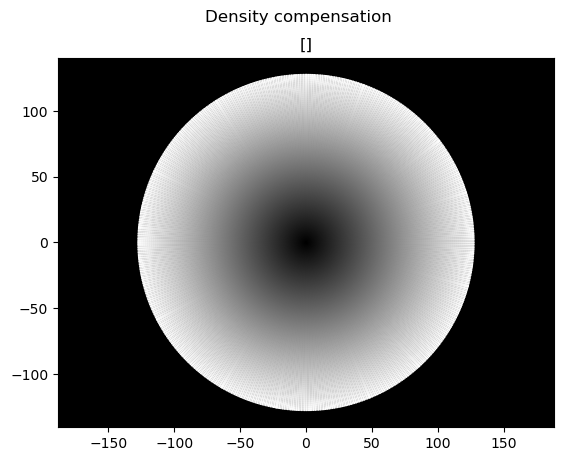

(256, 256)
(1000, 256, 2)


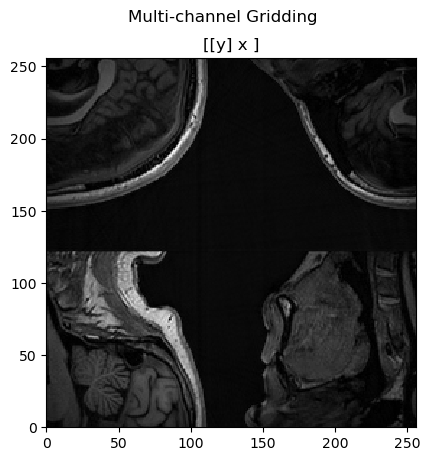

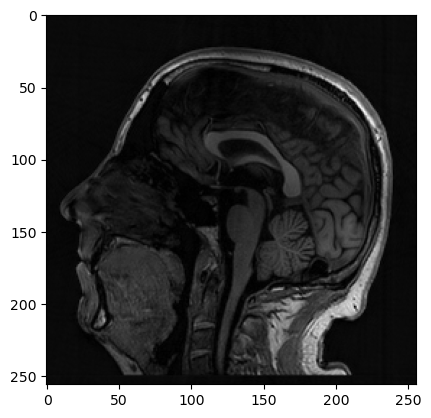

In [195]:
spikes = 1000

fft_t1_slice = sp.fft(t1_slice, center=False)
coord = sp.mri.radial((spikes,256,2), (256,256))
ksp = sp.interpolate(fft_t1_slice, coord)

# density compensated function
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
plot.ScatterPlot(coord, dcf, title='Density compensation')

img_grid = sp.nufft_adjoint(ksp * dcf, coord, oshape=(256, 256))
print(img_grid.shape)
print(coord.shape)
plot.ImagePlot(img_grid, title='Multi-channel Gridding')

img_grid = np.fft.fftshift(img_grid)
plt.imshow(abs(img_grid), cmap="gray")
plt.show()



In [196]:
import importlib

In [197]:
importlib.reload(sp)

<module 'sigpy' from '/Users/lasse/miniforge3/envs/hl2027/lib/python3.8/site-packages/sigpy/__init__.py'>